In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

sample_index=np.random.choice(traffic.index,40000,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))

# combs=np.array([[0,0,0]])
# for series in range(len(sample_series)):
#     change=diff(sample_series[series][1:-2])
#     comb=np.array([change[1:-2],change[2:-1],change[3:]]).T
#     combs=np.concatenate((combs,comb),axis=0)

In [102]:
changes=[]
for series in range(len(sample_series)):
    change=diff(sample_series[series][1:-2])
#     change[change>2]=2
    changes.append(change)

In [193]:
series

39999

In [103]:
changes=np.array(changes)

In [104]:
changes.shape

(40000, 799)

In [106]:
def num2index(num):
    return int((num+1) // 0.0025)

def index2num(index):
    return -1+(index+0.5)*0.0025

index2num(1199)



1.9987500000000002

In [107]:
#discrete change
dis_change=[]
for i in range(len(changes)):
    dis_change.append(list(map(lambda x:num2index(x),changes[i,:])))

In [108]:
dis_change=np.array(dis_change)

In [109]:
assert dis_change.shape==changes.shape

In [161]:
train_x=dis_change[:,265:365]
train_y=changes[:,365:365+63]
test_x=dis_change[:,400:500]
test_y=changes[:,500:500+63]

In [162]:
def X_loader(x,batchsize=10):
    batch=0
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        yield(torch.LongTensor(np.array(data, dtype=int)).cuda())
        batch+=1

In [163]:
def Y_loader(y,batchsize=10):
    batch=0
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        yield(torch.FloatTensor(np.array(data, dtype=float)).cuda())
        batch+=1

In [164]:
# changes[1,1:3]

In [165]:
import torch
import torch.nn as nn

class NN(nn.Module):
    def __init__(self, emb_dim,encoder_dim=150,out_dim=63, vocab_size=1200):
        super(NN, self).__init__()

        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.encoder = nn.GRU(emb_dim, encoder_dim, batch_first=True, bidirectional=False)
        self.decoder = nn.Linear(encoder_dim, out_dim)
    def forward(self, x):

        out = self.embed(x) 
#         print('embedding',out)
        output, hidden = self.encoder(out)
#         print('hidden',hidden)
        output = self.decoder(hidden)
        return output.squeeze()

In [174]:
model=NN(emb_dim=150,out_dim=63,vocab_size=1200).cuda()

In [172]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data,param.grad.data)

AttributeError: 'NoneType' object has no attribute 'data'

In [175]:
from torch import optim
epoch=2
indicator=200
for i in range(epoch):
    trainx=X_loader(train_x)
    trainy=Y_loader(train_y)
    running_loss = 0.0
    validation(test_x,test_y)
    for j,X_batch in enumerate(trainx):
        #Parse loaded batch
        
        model.train()
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
            eps=1e-08, weight_decay=0, momentum=0, centered=False)
        optimizer.zero_grad()
        output = model(X_batch)
        
        MSE = nn.MSELoss()
        target=next(trainy)
        loss = MSE(output,target)

        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        optimizer.step()

        running_loss += loss.item()

        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; Loss: {}\n".format(i, j, running_loss / indicator))
            running_loss = 0.0
#             for name, param in model.named_parameters():
#                 if param.requires_grad:
#                     print (name, param.data,param.grad.data)
#             print(output)


VALIDATION: Epoch: 0; Loss: 0.3768151765484772

Epoch: 0; iterations: 200; Loss: 0.37571775443851946

Epoch: 0; iterations: 400; Loss: 0.35372768316417935

Epoch: 0; iterations: 600; Loss: 0.35100590538233517

Epoch: 0; iterations: 800; Loss: 0.33072810985147955

Epoch: 0; iterations: 1000; Loss: 0.3362841112539172

Epoch: 0; iterations: 1200; Loss: 0.3334719221666455

Epoch: 0; iterations: 1400; Loss: 0.3253766306489706

Epoch: 0; iterations: 1600; Loss: 0.33528897654265166

Epoch: 0; iterations: 1800; Loss: 0.32744866847991944

Epoch: 0; iterations: 2000; Loss: 0.33502098988741635

Epoch: 0; iterations: 2200; Loss: 0.34249288238584996

Epoch: 0; iterations: 2400; Loss: 0.3339606670662761

Epoch: 0; iterations: 2600; Loss: 0.33839512564241886

Epoch: 0; iterations: 2800; Loss: 0.33823830481618644

Epoch: 0; iterations: 3000; Loss: 0.32870021447539327

Epoch: 0; iterations: 3200; Loss: 0.3248338760063052

Epoch: 0; iterations: 3400; Loss: 0.33453338030725716

Epoch: 0; iterations: 3600

In [119]:
def validation(test_x,test_y):
    testx=X_loader(test_x)
    testy=Y_loader(test_y)
    running_loss = 0.0
    for j,X_batch in enumerate(testx):
        #Parse loaded batch
        
        model.eval()
        output = model(X_batch)
        MSE = nn.MSELoss()
        target=next(testy)
        loss = MSE(output,target)
        running_loss += loss.item()
        print(j,end='\r')
        if j >500:
            break
    print("VALIDATION: Epoch: {}; Loss: {}\n".format(i, running_loss / j))


In [176]:
testx=X_loader(test_x)
testy=Y_loader(test_y)
running_loss = 0.0
for j,X_batch in enumerate(testx):
    #Parse loaded batch

    model.eval()
    output = model(X_batch)
    MSE = nn.MSELoss()
    target=next(testy)


In [180]:
out=output.detach().cpu().numpy()
target=target.detach().cpu().numpy()

In [191]:
def recover(start,change):
    series=[]
    last=start
    for c in change:
        last=last*(1+c)
        series.append(last)
    return series

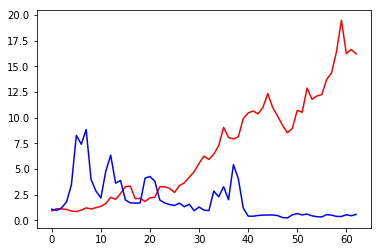

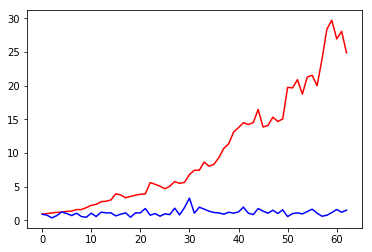

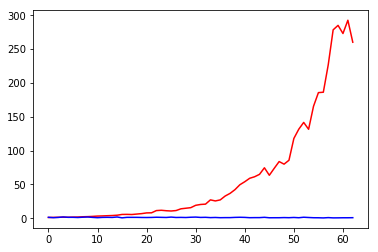

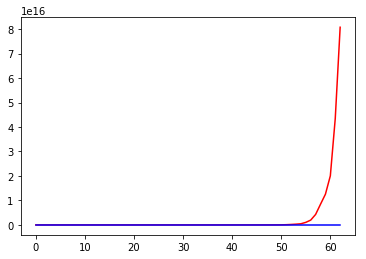

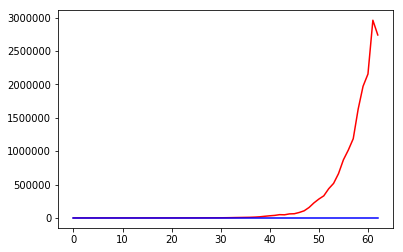

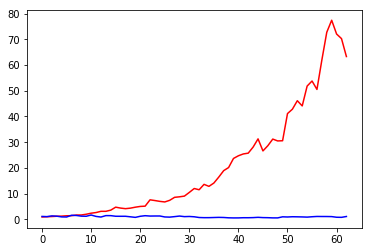

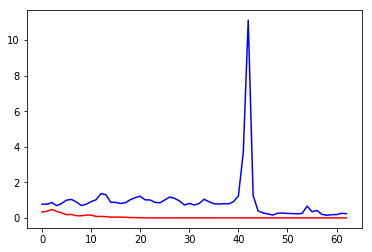

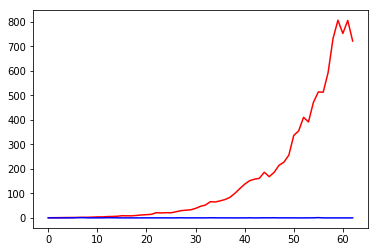

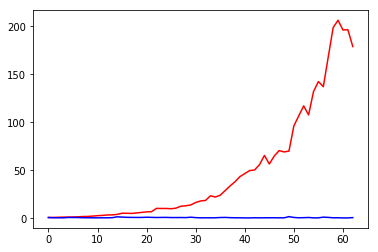

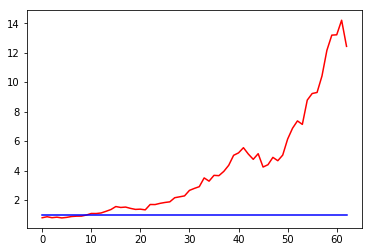

In [192]:
for i in range(10):
    plt.figure()
    plt.plot(recover(1,out[i,:]),color='r')
    plt.plot(recover(1,target[i,:]),color='b')